# Лабораторная работа №2


## Выполнил: Шамбилов Руслан

1. Загрузим библиотеки

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.datasets import load_diabetes 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.decomposition import PCA 
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb  
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,  classification_report
from sklearn.base import BaseEstimator, TransformerMixin


### Задание 1. Написать класс, реализующий свой линейный классификатор и логистическую регрессию с методами fit и predict.

In [4]:
class MyLinearLogisticClassifier:
    def __init__(self, learning_rate=0.01, num_iterations=1000):

        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.num_iterations):

            linear_model = np.dot(X, self.weights) + self.bias
            
            predictions = self.sigmoid(linear_model)
                    
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)


            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):

        linear_model = np.dot(X, self.weights) + self.bias

        predictions = self.sigmoid(linear_model)
        
        return (predictions >= 0.5).astype(int)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


### Задание 2. Решить задачу с помощью готовых реализаций:
### — Логистическая регрессия: sklearn
### — SVM: sklearn
### — Решающее дерево: sklearn
### — Случайный лес: sklearn
### — Градиентный бустинг: sklearn, LightGBM, XGBoost, catboost

2. Загрузим датасет, по предыдущему опыту контеста, очистим данные от дубликатов и пустых значений

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train = df_train.dropna().drop_duplicates()
df_test = df_test.dropna().drop_duplicates()

3. Так же отловим выбросы у признака RiskScore, график котрого выглядит следующим образом.

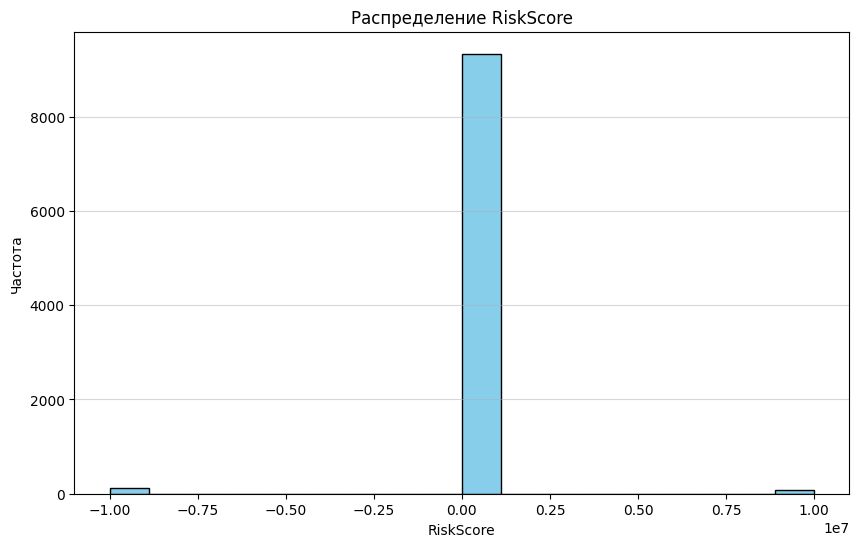

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df_train['RiskScore'], bins=18, color='skyblue', edgecolor='black')
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

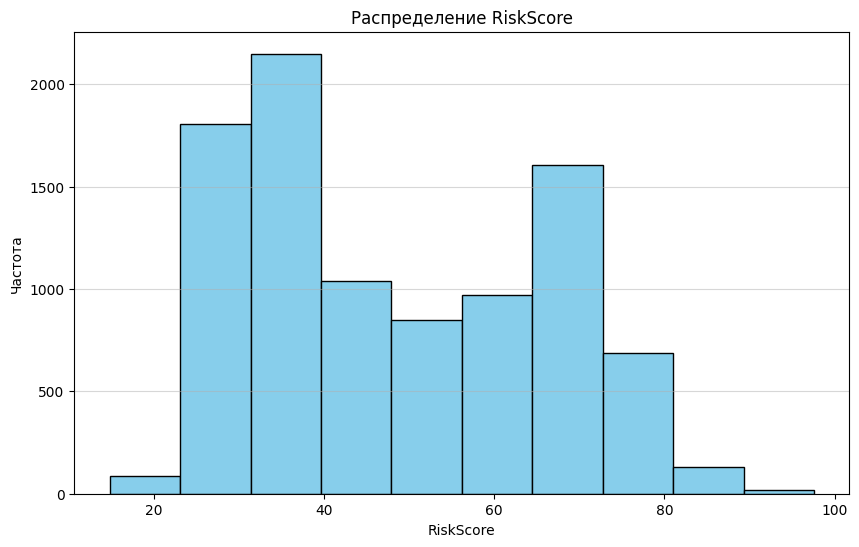

In [7]:
df_train = df_train[(df_train['RiskScore'] >= 0) & (df_train['RiskScore'] <= 100)]
plt.figure(figsize=(10, 6))
plt.hist(df_train['RiskScore'], bins=10, color='skyblue', edgecolor='black')
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.5)
plt.show()

4. Просмотрим данные

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9332 non-null   object 
 1   Age                         9332 non-null   float64
 2   AnnualIncome                9332 non-null   float64
 3   CreditScore                 9332 non-null   float64
 4   LoanAmount                  9332 non-null   float64
 5   LoanDuration                9332 non-null   float64
 6   MaritalStatus               9332 non-null   object 
 7   NumberOfDependents          9332 non-null   float64
 8   HomeOwnershipStatus         9332 non-null   object 
 9   MonthlyDebtPayments         9332 non-null   float64
 10  CreditCardUtilizationRate   9332 non-null   float64
 11  NumberOfOpenCreditLines     9332 non-null   float64
 12  NumberOfCreditInquiries     9332 non-null   float64
 13  DebtToIncomeRatio           9332 non-n

5. Теперь займемся объектами

In [9]:
for _ in df_train.select_dtypes(include=['object']).columns:
    print(f'{_}: {df_train[_].unique()}')

ApplicationDate: ['2010-06-26' '1996-09-23' '2015-01-19' ... '2000-03-10' '2010-04-05'
 '2001-12-28']
MaritalStatus: ['Divorced' 'Widowed' 'Married' 'Single']
HomeOwnershipStatus: ['Rent' 'Mortgage' 'Other' 'Own']
LoanPurpose: ['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']
EmploymentStatus: ['Employed' 'Self-Employed' 'Unemployed']
EducationLevel: ['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


Поскольку дата представляет собой временную информацию, её следует преобразовать в числовое представление, например, в годы или дни от какой-то базовой даты. Но проще всего ее будет просто убрать из датасета, ибо в себе никакой полезной информации она не несет.

In [10]:
df_train = df_train.drop(columns=['ApplicationDate'])

Для остальных применим Label Encoding

In [11]:
df_train['EducationLevel'] = LabelEncoder().fit_transform(df_train['EducationLevel'])
df_train['EmploymentStatus'] = LabelEncoder().fit_transform(df_train['EmploymentStatus'])
df_train['MaritalStatus'] = LabelEncoder().fit_transform(df_train['MaritalStatus'])
df_train['HomeOwnershipStatus'] = LabelEncoder().fit_transform(df_train['HomeOwnershipStatus'])
df_train['LoanPurpose'] = LabelEncoder().fit_transform(df_train['LoanPurpose'])

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         9332 non-null   float64
 1   AnnualIncome                9332 non-null   float64
 2   CreditScore                 9332 non-null   float64
 3   LoanAmount                  9332 non-null   float64
 4   LoanDuration                9332 non-null   float64
 5   MaritalStatus               9332 non-null   int64  
 6   NumberOfDependents          9332 non-null   float64
 7   HomeOwnershipStatus         9332 non-null   int64  
 8   MonthlyDebtPayments         9332 non-null   float64
 9   CreditCardUtilizationRate   9332 non-null   float64
 10  NumberOfOpenCreditLines     9332 non-null   float64
 11  NumberOfCreditInquiries     9332 non-null   float64
 12  DebtToIncomeRatio           9332 non-null   float64
 13  BankruptcyHistory           9332 non-n

На корреляционной матрице рассмотрим зависимость признаков друг от друга

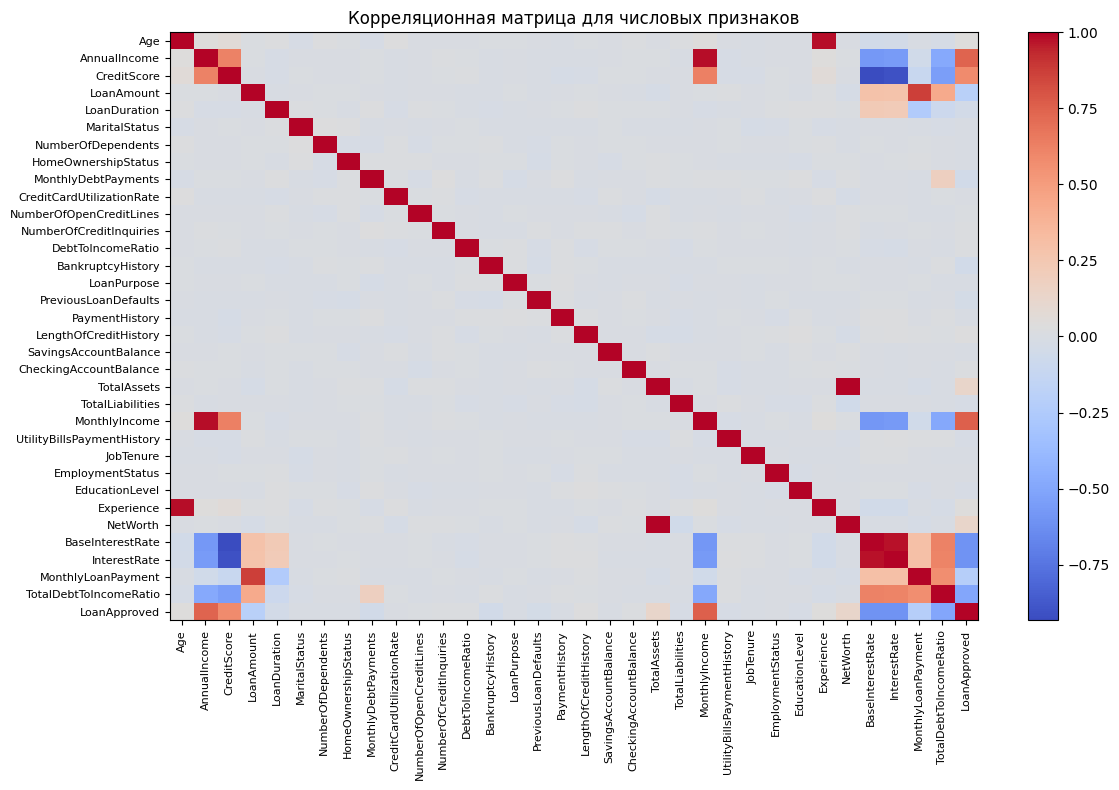

In [12]:
correlation_matrix = df_train.drop(['RiskScore'], axis=1).corr()

plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()

plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=8, rotation=90)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=8)

plt.title('Корреляционная матрица для числовых признаков', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
high_corr = correlation_matrix[(correlation_matrix >= 0.75) & (correlation_matrix != 1)].stack()
print(high_corr)

Age                 Experience            0.982802
AnnualIncome        MonthlyIncome         0.984441
LoanAmount          MonthlyLoanPayment    0.868404
TotalAssets         NetWorth              0.993819
MonthlyIncome       AnnualIncome          0.984441
                    LoanApproved          0.754705
Experience          Age                   0.982802
NetWorth            TotalAssets           0.993819
BaseInterestRate    InterestRate          0.975215
InterestRate        BaseInterestRate      0.975215
MonthlyLoanPayment  LoanAmount            0.868404
LoanApproved        MonthlyIncome         0.754705
dtype: float64


Уберем признаки, чья корреляция больше 0.75

In [14]:
df_train.drop(['Experience', 'MonthlyIncome', 'MonthlyLoanPayment', 'NetWorth', 'BaseInterestRate'], axis=1, inplace=True)

6. Создадим функцию для метрик

In [15]:
def get_metrics_and_matrix(y_test,y_pred): 
    precision = precision_score(y_test, y_pred, average='binary') 
    recall = recall_score(y_test, y_pred, average='binary') 
    f1 = f1_score(y_test, y_pred, average='binary') 
    accuracy = accuracy_score(y_test, y_pred) 

    print('Evaluation Metrics: ')
    print(f"Accuracy: {accuracy}") 
    print(f"Precision: {precision}") 
    print(f"Recall: {recall}") 
    print(f"F1 Score: {f1}") 

    conf_matrix = confusion_matrix(y_test, y_pred) 
 
    plt.figure(figsize=(6, 4)) 
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["0", "1"], yticklabels=["0", "1"]) 
    plt.title("Confusion Matrix") 
    plt.xlabel("Predicted") 
    plt.ylabel("True") 
    plt.show()

7. Определим трансформ

In [16]:

class LabelEncoderTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self): 
        self.le = {} 
        self.le_features = ['EducationLevel', 'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose'] 
 
    def fit(self, X, y=None): 
 
        self.X = X.copy() 
 
        for feature in self.le_features: 
          self.le[feature] = LabelEncoder() 
          self.le[feature].fit(self.X[feature]) 
 
        return self 
 
    def transform(self, X): 
 
        self.X = X.copy() 
 
        for feature in self.le_features: 
          self.X[feature] = self.le[feature].transform(self.X[feature]) 
 
        return self.X

8. Зададим тренировочный датасет

In [17]:
X_train, X_test, y_train, y_test = train_test_split( 
    df_train.drop(['LoanApproved'], axis=1), 
    df_train['LoanApproved'], 
    test_size=0.2, 
    random_state=42 
)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         9332 non-null   float64
 1   AnnualIncome                9332 non-null   float64
 2   CreditScore                 9332 non-null   float64
 3   LoanAmount                  9332 non-null   float64
 4   LoanDuration                9332 non-null   float64
 5   MaritalStatus               9332 non-null   int64  
 6   NumberOfDependents          9332 non-null   float64
 7   HomeOwnershipStatus         9332 non-null   int64  
 8   MonthlyDebtPayments         9332 non-null   float64
 9   CreditCardUtilizationRate   9332 non-null   float64
 10  NumberOfOpenCreditLines     9332 non-null   float64
 11  NumberOfCreditInquiries     9332 non-null   float64
 12  DebtToIncomeRatio           9332 non-null   float64
 13  BankruptcyHistory           9332 non-n

9. Посмотрим результаты

Evaluation Metrics: 
Accuracy: 0.9914301017675415
Precision: 0.9852786540483701
Recall: 0.9978700745473909
F1 Score: 0.9915343915343915


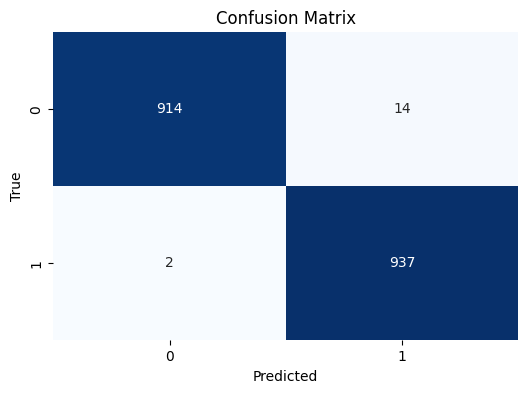

In [18]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9394750937332619
Precision: 0.9222903885480572
Recall: 0.9605963791267306
F1 Score: 0.9410537297861241


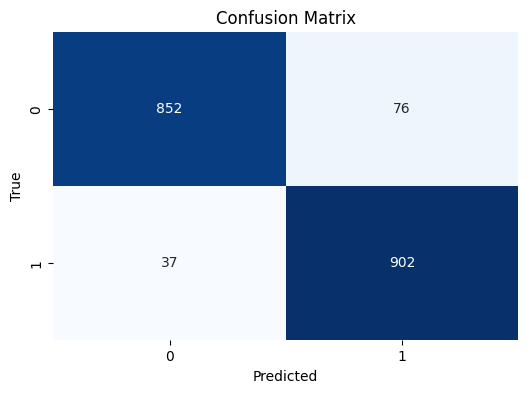

In [19]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', MyLinearLogisticClassifier()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9882163899303695
Precision: 0.9811122770199371
Recall: 0.9957401490947817
F1 Score: 0.9883720930232558


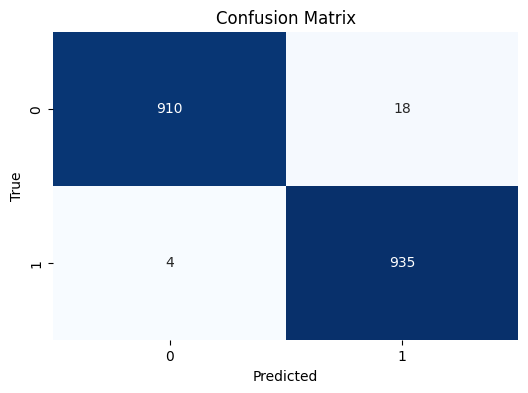

In [20]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', SVC()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9850026780931976
Precision: 0.9861259338313767
Recall: 0.9840255591054313
F1 Score: 0.9850746268656716


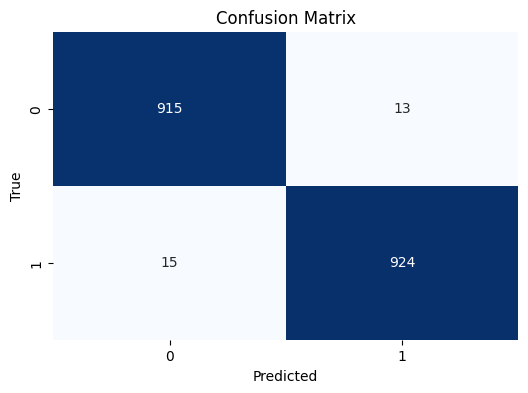

In [21]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', DecisionTreeClassifier()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9823245848955544
Precision: 0.9778481012658228
Recall: 0.987220447284345
F1 Score: 0.9825119236883942


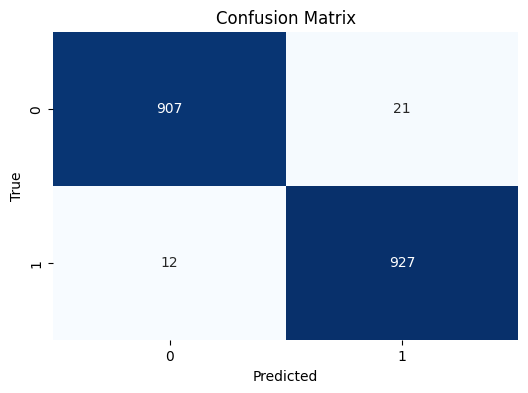

In [22]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', RandomForestClassifier()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9914301017675415
Precision: 0.9852786540483701
Recall: 0.9978700745473909
F1 Score: 0.9915343915343915


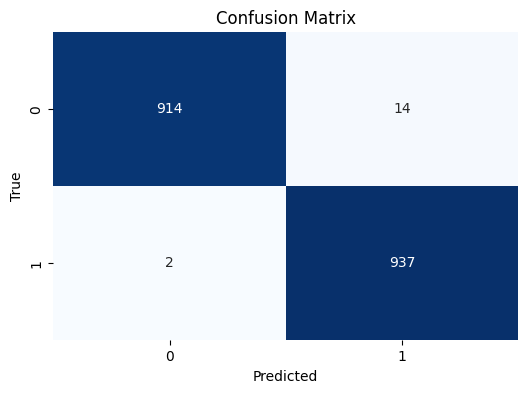

In [23]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', GradientBoostingClassifier()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

[LightGBM] [Info] Number of positive: 3850, number of negative: 3615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 7465, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515740 -> initscore=0.062981
[LightGBM] [Info] Start training from score 0.062981
Evaluation Metrics: 
Accuracy: 0.9951794322442421
Precision: 0.9946808510638298
Recall: 0.9957401490947817
F1 Score: 0.9952102182011708


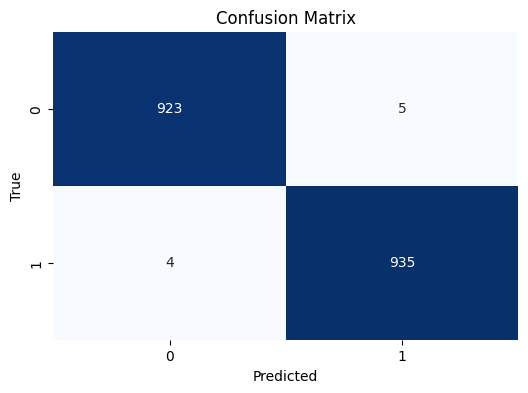

In [24]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', lgb.LGBMClassifier()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9941081949651848
Precision: 0.9925690021231423
Recall: 0.9957401490947817
F1 Score: 0.9941520467836257


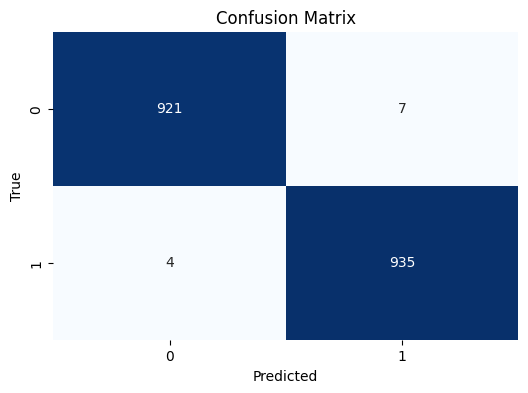

In [25]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', xgb.XGBClassifier()) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)

Evaluation Metrics: 
Accuracy: 0.9978575254418853
Precision: 0.9968119022316685
Recall: 0.9989350372736954
F1 Score: 0.997872340425532


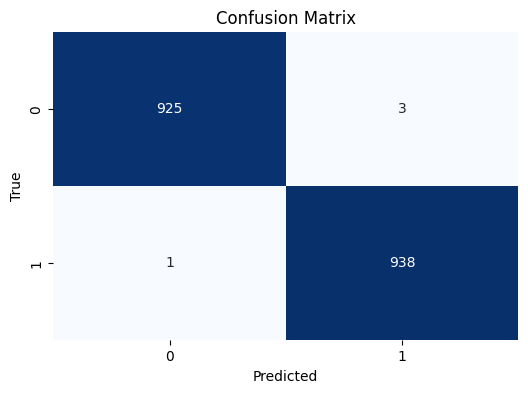

In [28]:
pipeLine = Pipeline([ 
    ('label_encoder', LabelEncoderTransformer()), 
    ('scaler', StandardScaler()), 
    ('model', CatBoostClassifier(verbose=0)) 
]) 
pipeLine.fit(X_train, y_train) 

y_test_pred = pipeLine.predict(X_test)

get_metrics_and_matrix(y_test, y_test_pred)